In [1]:
%run imports.py

Succesfully imported libraries and modules



## Creating dataframe with clinics

We need to have patient.updrs property for each patient. It should contain all available UPDRS assessment scores for each day, symptom and side. This property will be saved to each patient.

Also, dataframe with PAC, beta and HFO powers will be complemented with these scores. 
Needed properties: updrs_left_brady; updrs_left_rigidity; updrs_left_tremor

Предлагаю создать словарь со словарями:
condition: {left_bradyk: int, left_rigid: int, left_tremor: int, ...}

In [3]:
with open('path_data.txt', 'r') as file:
    data_path = file.readline()

In [4]:
p1 = load_patient(1)

Patient directory:  D:\LAB\AlexPAC\data\Patient1


In [10]:
patient = p1

df = pd.read_excel(os.path.join(patient.root_dir, f"{patient.name}_clinics.xls"), index_col=0)

In [11]:
df

,off-U3Right.Bradyk,off-u3Left.Bradyk,off-u3Right.Rigidity,off-u3Left.Rigidity,off-u3Right.Tremor,off-u3Left.Tremor,on-u3Right.Bradykin,on-u3Left.Bradykin,on-u3Right.Rigidity,on-u3Left.Rigidity,on-u3Right.Tremor,on-u3Left.Tremor
Operation,10,10,6,5,5,2,1,2,2,0,0,0
1Day,8,8,5,6,3,2,4,3,1,2,0,0
5Day,13,9,7,5,3,2,2,2,2,2,0,0


In [12]:
patient.clinics_dataframe = df

In [17]:
df.loc['1Day']['off-U3Right.Bradyk']

8

In [19]:
list(df.columns)

['off-U3Right.Bradyk',
 'off-u3Left.Bradyk',
 'off-u3Right.Rigidity',
 'off-u3Left.Rigidity',
 'off-u3Right.Tremor',
 'off-u3Left.Tremor',
 'on-u3Right.Bradykin',
 'on-u3Left.Bradykin',
 'on-u3Right.Rigidity',
 'on-u3Left.Rigidity',
 'on-u3Right.Tremor',
 'on-u3Left.Tremor']

In [20]:
conditions_rest = ["1Day OFF Rest 180sec", "1Day ON Rest 180sec", "5Day OFF Rest 180sec", "5Day ON Rest 180sec"]

conditions = [c for c in conditions_rest if c in patient.conditions]
clinics_keys = ["r_brady", "r_rigid", "r_tremor", "l_brady", "l_rigid", "l_tremor"]

df_new = pd.DataFrame(columns=clinics_keys, index=conditions)

clinics = defaultdict(dict)

for column in list(df.columns):
    ldopa = "OFF" if 'off' in column else 'ON'
    for day in list(df.index):
        if 'Day' not in day:
            continue
        condition = create_condition_name(day, ldopa, 'Rest 180sec')
        # side
        side = 'r' if "Right" in column else 'l'
        # symptom
        if "Brady" in column:
            key = side + '_brady'
        if "Rigid" in column:
            key = side + '_rigid'
        if "Tremor" in column:
            key = side + '_tremor'
        value = df.loc[day][column]
        clinics[condition][key] = value
        df_new.loc[condition][key] = value
        
        

In [21]:
df_new

,r_brady,r_rigid,r_tremor,l_brady,l_rigid,l_tremor
1Day OFF Rest 180sec,8,5,3,8,6,2
1Day ON Rest 180sec,4,1,0,3,2,0
5Day OFF Rest 180sec,13,7,3,9,5,2
5Day ON Rest 180sec,2,2,0,2,2,0


In [23]:
patient.clinics = df_new
patient.save()

Saving Patient1 object to D:\LAB\AlexPAC\data\Patient1\Patient1.pkl ...
Pickling Patient1 without ['pac']
Done, 2.187581777572632 sec
File size: 2788.229974746704 MB
Returning filepath for saved file


'D:\\LAB\\AlexPAC\\data\\Patient1\\Patient1.pkl'

### ADD l_mean_cross_pac and l_mean_inter_pac (as well as probably beta and hfo scores) to this table

In [26]:
df_power = pd.read_csv('beta_hfo_pac_powers_REST.csv', sep=',', index_col=0)

In [31]:
df_power['side'] = df_power['phase'].apply(lambda s: s[0])

In [34]:
df_power.head()

,patient,condition,phase,amplitude,beta_power,hfo_power,pac_power,is_cross_pac,side
0,Patient1,5Day OFF Rest 180sec,L2A-3A,L2A-3A,0.609522,0.000388,0.000000,0,L
1,Patient1,5Day OFF Rest 180sec,L2A-3A,L4-3B,0.609522,0.000318,0.000155,1,L
2,Patient1,5Day OFF Rest 180sec,L2A-3A,L2C-3C,0.609522,0.000405,0.000000,1,L
3,Patient1,5Day OFF Rest 180sec,L2A-3A,L4-3A,0.609522,0.000418,0.000213,1,L
4,Patient1,5Day OFF Rest 180sec,L2A-3A,L1-2C,0.609522,0.000175,0.000000,1,L


In [37]:
#def get_mean_cross_pac(patient, condition):
df_patient = df_power[df_power.patient == patient.name]
df_condition = df_patient[df_patient.condition == condition]
print(df_condition.groupby('is_cross_pac').mean())

l_mean_cross_pac = df_condition[(df_condition.side == 'L') & (df_condition.is_cross_pac == 1)]['pac_power'].mean()
l_mean_cross_pac

              beta_power  hfo_power  pac_power
is_cross_pac                                  
0               0.404905   0.000407   0.000059
1               0.392046   0.000438   0.000058


1.902310745704486e-05

In [40]:
def get_mean_pac_values(patient, condition):
    df_patient = df_power[df_power.patient == patient.name]
    df_cond = df_patient[df_patient.condition == condition]
    
    l_mean_cross_pac = df_cond[(df_cond.side == 'L') & (df_cond.is_cross_pac == 1)]['pac_power'].mean()
    r_mean_cross_pac = df_cond[(df_cond.side == 'R') & (df_cond.is_cross_pac == 1)]['pac_power'].mean()
    l_mean_inter_pac = df_cond[(df_cond.side == 'L') & (df_cond.is_cross_pac == 0)]['pac_power'].mean()
    r_mean_inter_pac = df_cond[(df_cond.side == 'R') & (df_cond.is_cross_pac == 0)]['pac_power'].mean()
    
    return l_mean_cross_pac, l_mean_inter_pac, r_mean_cross_pac, r_mean_inter_pac

In [45]:
clinics_with_pac = df_new.copy()
pac_columns = ['l_mean_inter_pac', 'l_mean_cross_pac', 'r_mean_inter_pac', 'r_mean_cross_pac']
for column in pac_columns:
    clinics_with_pac[column] = np.nan
    
l_mean_cross_pacs, l_mean_inter_pacs, r_mean_cross_pacs, r_mean_inter_pacs = [], [], [], []
for condition in conditions:
    l_mean_cross_pac, l_mean_inter_pac, r_mean_cross_pac, r_mean_inter_pac = get_mean_pac_values(patient, condition)
    
    l_mean_cross_pacs.append(l_mean_cross_pac)
    r_mean_cross_pacs.append(r_mean_cross_pac)
    l_mean_inter_pacs.append(l_mean_inter_pac)
    r_mean_inter_pacs.append(r_mean_inter_pac)
    
pac_dict = {name: values for name, values in zip(pac_columns, [l_mean_cross_pacs, l_mean_inter_pacs, r_mean_cross_pacs, r_mean_inter_pacs])}

for column in pac_columns:
    clinics_with_pac[column] = pac_dict[column]
    
patient.clinics_with_pac = clinics_with_pac

In [46]:
clinics_with_pac

,r_brady,r_rigid,r_tremor,l_brady,l_rigid,l_tremor,l_mean_inter_pac,l_mean_cross_pac,r_mean_inter_pac,r_mean_cross_pac
1Day OFF Rest 180sec,8,5,3,8,6,2,0.000022,0.000033,0.000081,0.000133
1Day ON Rest 180sec,4,1,0,3,2,0,0.000027,0.000008,0.000071,0.000029
5Day OFF Rest 180sec,13,7,3,9,5,2,0.000149,0.000058,0.000379,0.000326
5Day ON Rest 180sec,2,2,0,2,2,0,0.000019,0.000032,0.000098,0.000086


In [48]:
# patient 3 - test
#
p1 = load_patient(1)
p2 = load_patient(2)
p3 = load_patient(3)
p4 = load_patient(4)
p5 = load_patient(5)
#p6 = load_patient(6)

Patient directory:  D:\LAB\AlexPAC\data\Patient1
Patient directory:  D:\LAB\AlexPAC\data\Patient2
Patient directory:  D:\LAB\AlexPAC\data\Patient3
Patient directory:  D:\LAB\AlexPAC\data\Patient4
Patient directory:  D:\LAB\AlexPAC\data\Patient5


### Calculate same dataframes for each patient available

In [49]:
clinics_with_pac_list = []

for patient in [p1, p2, p3, p4, p5]:
    
    df = pd.read_excel(os.path.join(patient.root_dir, f"{patient.name}_clinics.xls"), index_col=0)

    conditions_rest = ["1Day OFF Rest 180sec", "1Day ON Rest 180sec", "5Day OFF Rest 180sec", "5Day ON Rest 180sec"]

    conditions = [c for c in conditions_rest if c in patient.conditions]
    clinics_keys = ["r_brady", "r_rigid", "r_tremor", "l_brady", "l_rigid", "l_tremor"]

    df_new = pd.DataFrame(columns=clinics_keys, index=conditions)

    clinics = defaultdict(dict)

    for column in list(df.columns):
        ldopa = "OFF" if 'off' in column else 'ON'
        for day in list(df.index):
            if 'Day' not in day:
                continue
            condition = create_condition_name(day, ldopa, 'Rest 180sec')
            # side
            side = 'r' if "Right" in column else 'l'
            # symptom
            if "Brady" in column:
                key = side + '_brady'
            if "Rigid" in column:
                key = side + '_rigid'
            if "Tremor" in column:
                key = side + '_tremor'
            value = df.loc[day][column]
            clinics[condition][key] = value
            df_new.loc[condition][key] = value

    patient.clinics = df_new

    df_power = pd.read_csv('beta_hfo_pac_powers_REST.csv', sep=',', index_col=0)
    df_power['side'] = df_power['phase'].apply(lambda s: s[0])


    clinics_with_pac = df_new.copy()
    pac_columns = ['l_mean_inter_pac', 'l_mean_cross_pac', 'r_mean_inter_pac', 'r_mean_cross_pac']
    for column in pac_columns:
        clinics_with_pac[column] = np.nan

    l_mean_cross_pacs, l_mean_inter_pacs, r_mean_cross_pacs, r_mean_inter_pacs = [], [], [], []
    for condition in conditions:
        l_mean_cross_pac, l_mean_inter_pac, r_mean_cross_pac, r_mean_inter_pac = get_mean_pac_values(patient, condition)

        l_mean_cross_pacs.append(l_mean_cross_pac)
        r_mean_cross_pacs.append(r_mean_cross_pac)
        l_mean_inter_pacs.append(l_mean_inter_pac)
        r_mean_inter_pacs.append(r_mean_inter_pac)

    pac_dict = {name: values for name, values in zip(pac_columns, [l_mean_cross_pacs, l_mean_inter_pacs, r_mean_cross_pacs, r_mean_inter_pacs])}

    for column in pac_columns:
        clinics_with_pac[column] = pac_dict[column]

    patient.clinics_with_pac = clinics_with_pac
    patient.save()
    clinics_with_pac_list.append(clinics_with_pac)

Saving Patient1 object to D:\LAB\AlexPAC\data\Patient1\Patient1.pkl ...
Pickling Patient1 without ['pac']
Done, 15.118517875671387 sec
File size: 2788.2312774658203 MB
Returning filepath for saved file
Saving Patient2 object to D:\LAB\AlexPAC\data\Patient2\Patient2.pkl ...
Pickling Patient2 without ['pac']
Done, 6.3559229373931885 sec
File size: 1852.8679571151733 MB
Returning filepath for saved file
Saving Patient3 object to D:\LAB\AlexPAC\data\Patient3\Patient3.pkl ...
Pickling Patient3 without ['pac']
Done, 14.181960582733154 sec
File size: 3449.7641525268555 MB
Returning filepath for saved file
Saving Patient4 object to D:\LAB\AlexPAC\data\Patient4\Patient4.pkl ...
Pickling Patient4 without ['pac']
Done, 8.863559246063232 sec
File size: 2330.3171939849854 MB
Returning filepath for saved file
Saving Patient5 object to D:\LAB\AlexPAC\data\Patient5\Patient5.pkl ...
Pickling Patient5 without ['pac']
Done, 10.462589979171753 sec
File size: 3022.9283027648926 MB
Returning filepath for sa

### Get global clinics and PAC table

In [51]:
for df in clinics_with_pac_list:
    print("_____________________________________________________")
    print(df)

_____________________________________________________
                     r_brady r_rigid r_tremor l_brady l_rigid l_tremor  \
1Day OFF Rest 180sec       8       5        3       8       6        2   
1Day ON Rest 180sec        4       1        0       3       2        0   
5Day OFF Rest 180sec      13       7        3       9       5        2   
5Day ON Rest 180sec        2       2        0       2       2        0   

                      l_mean_inter_pac  l_mean_cross_pac  r_mean_inter_pac  \
1Day OFF Rest 180sec          0.000022          0.000033          0.000081   
1Day ON Rest 180sec           0.000027          0.000008          0.000071   
5Day OFF Rest 180sec          0.000149          0.000058          0.000379   
5Day ON Rest 180sec           0.000019          0.000032          0.000098   

                      r_mean_cross_pac  
1Day OFF Rest 180sec          0.000133  
1Day ON Rest 180sec           0.000029  
5Day OFF Rest 180sec          0.000326  
5Day ON Rest 180sec 

In [52]:
patients = [p1, p2, p3, p4, p5]

for i, df in enumerate(clinics_with_pac_list):
    df['patient'] = patients[i].name

In [54]:
df_clinics_with_pac = pd.concat(clinics_with_pac_list, ignore_index=True)

In [55]:
df_clinics_with_pac

,r_brady,r_rigid,r_tremor,l_brady,l_rigid,l_tremor,l_mean_inter_pac,l_mean_cross_pac,r_mean_inter_pac,r_mean_cross_pac,patient
0,8,5,3,8,6,2,0.000022,0.000033,0.000081,0.000133,Patient1
1,4,1,0,3,2,0,0.000027,0.000008,0.000071,0.000029,Patient1
2,13,7,3,9,5,2,0.000149,0.000058,0.000379,0.000326,Patient1
3,2,2,0,2,2,0,0.000019,0.000032,0.000098,0.000086,Patient1
4,NaN,NaN,NaN,NaN,NaN,NaN,0.000063,0.000100,0.000245,0.000152,Patient2
5,NaN,NaN,NaN,NaN,NaN,NaN,0.000065,0.000119,0.000130,0.000115,Patient2
6,5,4,0,6,6,0,0.000438,0.000394,0.000064,0.000150,Patient2
7,0,1,0,1,1,0,0.000090,0.000077,0.000013,0.000065,Patient2
8,3,6,0,2,5,0,0.000312,0.000323,0.000088,0.000096,Patient3
9,1,1,0,0,1,0,0.000033,0.000009,0.000090,0.000097,Patient3


In [56]:
df_clinics_with_pac.to_csv('clinics_with_pac.csv', sep=',')

In [57]:
df_clinics_with_pac.dropna()

,r_brady,r_rigid,r_tremor,l_brady,l_rigid,l_tremor,l_mean_inter_pac,l_mean_cross_pac,r_mean_inter_pac,r_mean_cross_pac,patient
0,8,5,3,8,6,2,0.000022,0.000033,0.000081,0.000133,Patient1
1,4,1,0,3,2,0,0.000027,0.000008,0.000071,0.000029,Patient1
2,13,7,3,9,5,2,0.000149,0.000058,0.000379,0.000326,Patient1
3,2,2,0,2,2,0,0.000019,0.000032,0.000098,0.000086,Patient1
6,5,4,0,6,6,0,0.000438,0.000394,0.000064,0.000150,Patient2
7,0,1,0,1,1,0,0.000090,0.000077,0.000013,0.000065,Patient2
8,3,6,0,2,5,0,0.000312,0.000323,0.000088,0.000096,Patient3
9,1,1,0,0,1,0,0.000033,0.000009,0.000090,0.000097,Patient3
10,12,4,2,10,6,2,0.000218,0.000327,0.000164,0.000252,Patient3
11,0,1,0,0,2,0,0.000133,0.000155,0.000065,0.000125,Patient3


In [60]:
df = df_clinics_with_pac.dropna()

In [61]:
df

,r_brady,r_rigid,r_tremor,l_brady,l_rigid,l_tremor,l_mean_inter_pac,l_mean_cross_pac,r_mean_inter_pac,r_mean_cross_pac,patient
0,8,5,3,8,6,2,0.000022,0.000033,0.000081,0.000133,Patient1
1,4,1,0,3,2,0,0.000027,0.000008,0.000071,0.000029,Patient1
2,13,7,3,9,5,2,0.000149,0.000058,0.000379,0.000326,Patient1
3,2,2,0,2,2,0,0.000019,0.000032,0.000098,0.000086,Patient1
6,5,4,0,6,6,0,0.000438,0.000394,0.000064,0.000150,Patient2
7,0,1,0,1,1,0,0.000090,0.000077,0.000013,0.000065,Patient2
8,3,6,0,2,5,0,0.000312,0.000323,0.000088,0.000096,Patient3
9,1,1,0,0,1,0,0.000033,0.000009,0.000090,0.000097,Patient3
10,12,4,2,10,6,2,0.000218,0.000327,0.000164,0.000252,Patient3
11,0,1,0,0,2,0,0.000133,0.000155,0.000065,0.000125,Patient3


In [65]:
df.corr()

,l_mean_inter_pac,l_mean_cross_pac,r_mean_inter_pac,r_mean_cross_pac
l_mean_inter_pac,1.000000,0.968919,0.071956,0.075817
l_mean_cross_pac,0.968919,1.000000,-0.012388,0.081767
r_mean_inter_pac,0.071956,-0.012388,1.000000,0.779596
r_mean_cross_pac,0.075817,0.081767,0.779596,1.000000


In [72]:
df[df.columns[:-1]] = df[df.columns[:-1]].astype(float)

C:\Users\aleks\anaconda3\envs\pac\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [74]:
df.corr()

,r_brady,r_rigid,r_tremor,l_brady,l_rigid,l_tremor,l_mean_inter_pac,l_mean_cross_pac,r_mean_inter_pac,r_mean_cross_pac
r_brady,1.000000,0.749616,0.820667,0.856962,0.502953,0.640687,-0.056388,-0.109416,0.465364,0.313172
r_rigid,0.749616,1.000000,0.746203,0.616028,0.758858,0.618853,0.112835,0.036249,0.583259,0.526731
r_tremor,0.820667,0.746203,1.000000,0.660056,0.584838,0.835619,-0.251074,-0.278209,0.556608,0.568856
l_brady,0.856962,0.616028,0.660056,1.000000,0.595247,0.677744,0.265642,0.226855,0.410515,0.218351
l_rigid,0.502953,0.758858,0.584838,0.595247,1.000000,0.649353,0.397801,0.404270,0.449096,0.632471
l_tremor,0.640687,0.618853,0.835619,0.677744,0.649353,1.000000,-0.035621,-0.036906,0.693210,0.657468
l_mean_inter_pac,-0.056388,0.112835,-0.251074,0.265642,0.397801,-0.035621,1.000000,0.968919,0.071956,0.075817
l_mean_cross_pac,-0.109416,0.036249,-0.278209,0.226855,0.404270,-0.036906,0.968919,1.000000,-0.012388,0.081767
r_mean_inter_pac,0.465364,0.583259,0.556608,0.410515,0.449096,0.693210,0.071956,-0.012388,1.000000,0.779596
r_mean_cross_pac,0.313172,0.526731,0.568856,0.218351,0.632471,0.657468,0.075817,0.081767,0.779596,1.000000


In [76]:
df.to_csv('clinics_with_pac.csv', sep=',')

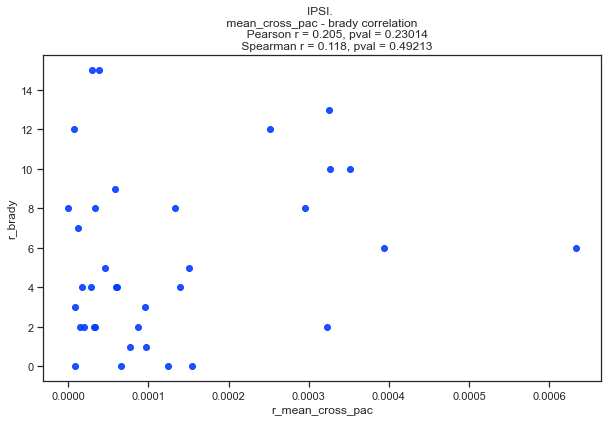

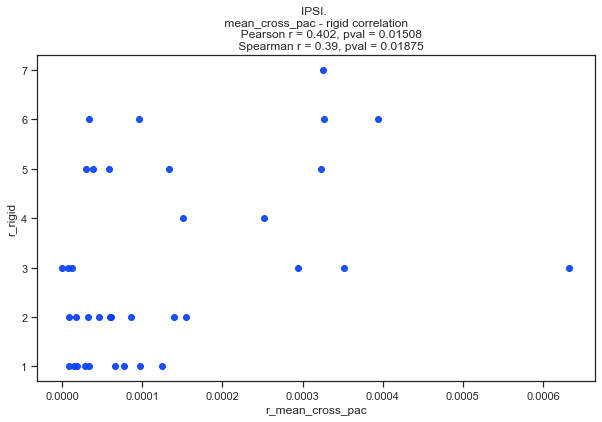

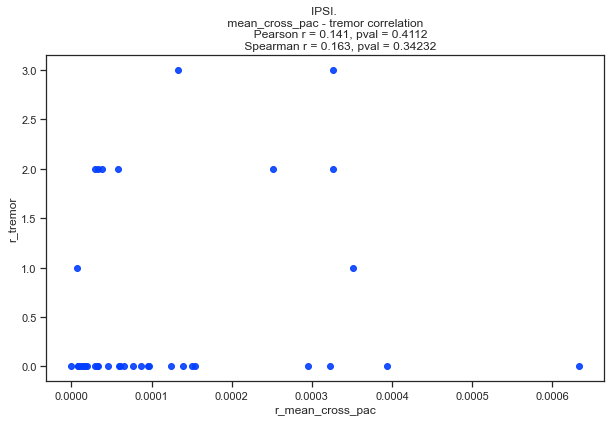

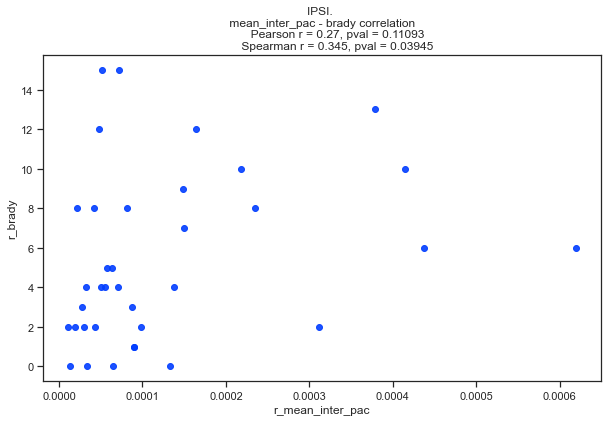

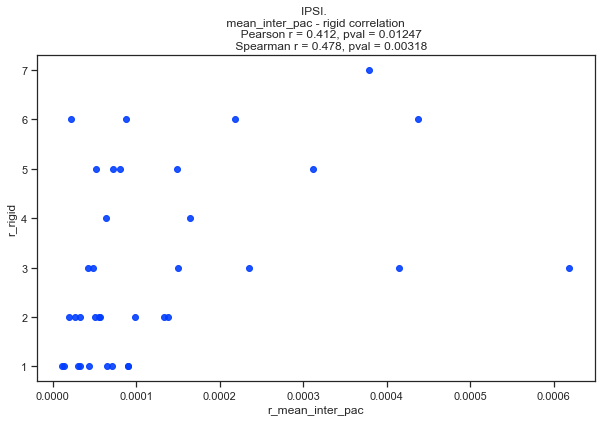

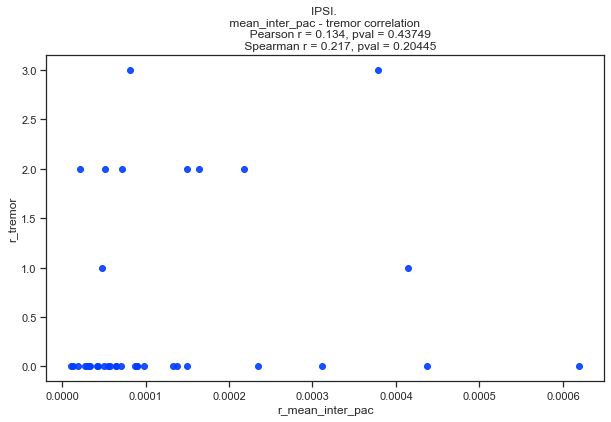

In [85]:
sides = ['l', 'r']
sides_titles = ["LEFT", "RIGHT"]

# IPSI

for pac_type in ['mean_cross_pac', 'mean_inter_pac']:
    for symptom in ['brady', 'rigid', 'tremor']:
        x1 = df[f"{sides[0]}_{pac_type}"]
        y1 = df[f"{sides[0]}_{symptom}"]
        # regardless of side, choose ipsilateral data
        x2 = df[f"{sides[1]}_{pac_type}"]
        y2 = df[f"{sides[1]}_{symptom}"]
        
        x = pd.concat((x1, x2), ignore_index=True)
        y = pd.concat((y1, y2), ignore_index=True)
        
        rho_p, pval_p = stats.pearsonr(x, y)
        rho_s, pval_s = stats.spearmanr(x, y)
        title = f"IPSI. \n {pac_type} - {symptom} correlation \n  \
        Pearson r = {round(rho_p, 3)}, pval = {round(pval_p, 5)} \n \
        Spearman r = {round(rho_s, 3)}, pval = {round(pval_s, 5)}"
        plt.scatter(x, y, alpha=0.9)
        plt.title(title)
        plt.xlabel(f"{sides[i]}_{pac_type}")
        plt.ylabel(f"{sides[i]}_{symptom}")
        plt.show()

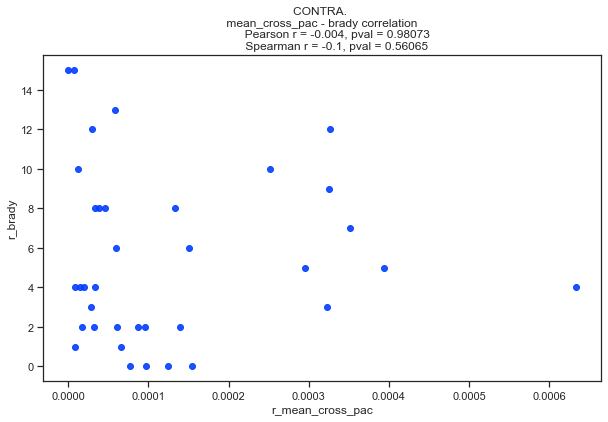

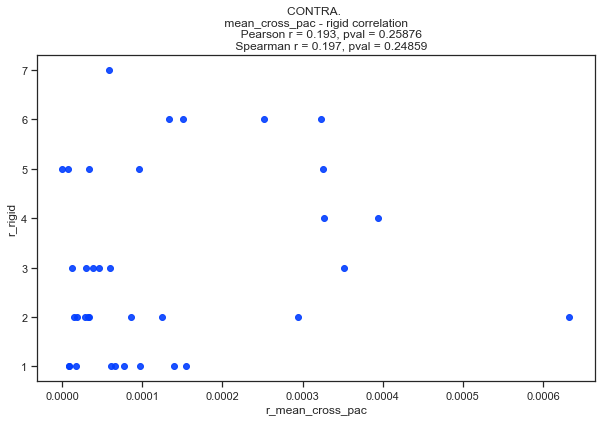

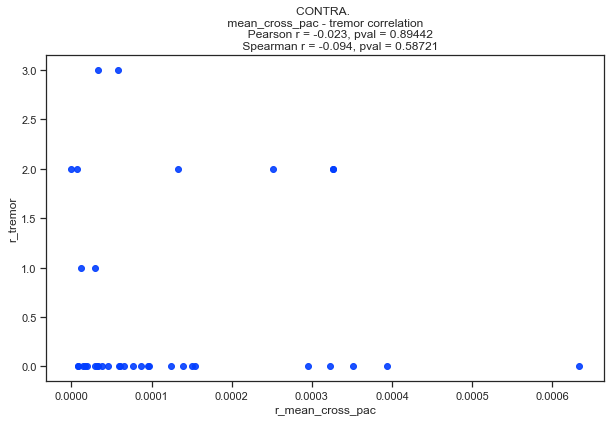

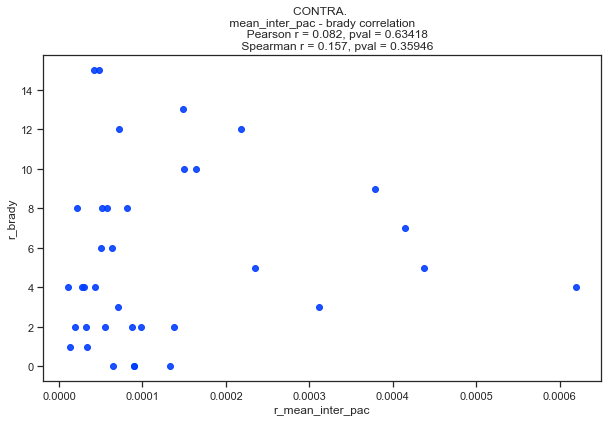

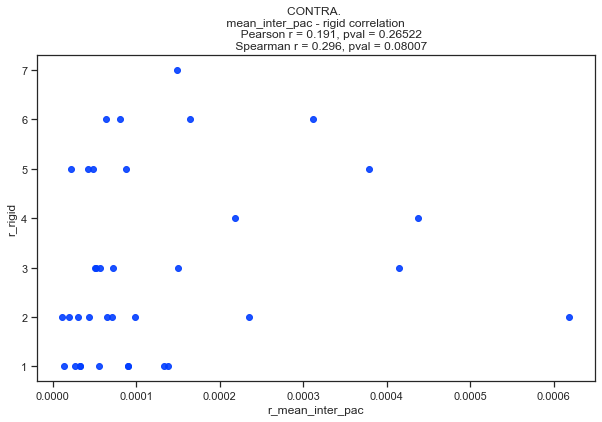

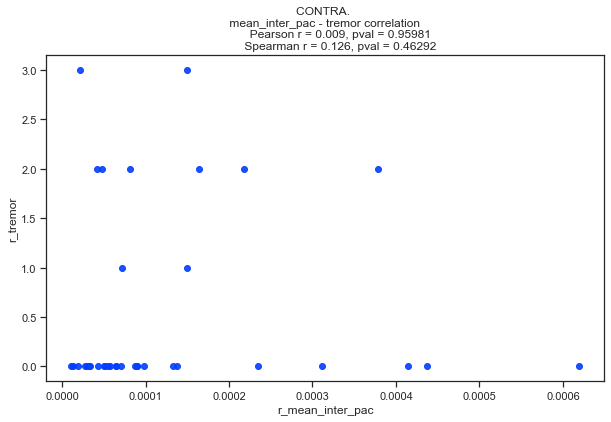

In [86]:
sides = ['l', 'r']
sides_titles = ["LEFT", "RIGHT"]

# IPSI

for pac_type in ['mean_cross_pac', 'mean_inter_pac']:
    for symptom in ['brady', 'rigid', 'tremor']:
        x1 = df[f"{sides[0]}_{pac_type}"]
        y1 = df[f"{sides[1]}_{symptom}"]
        # regardless of side, choose ipsilateral data
        x2 = df[f"{sides[1]}_{pac_type}"]
        y2 = df[f"{sides[0]}_{symptom}"]
        
        x = pd.concat((x1, x2), ignore_index=True)
        y = pd.concat((y1, y2), ignore_index=True)
        
        rho_p, pval_p = stats.pearsonr(x, y)
        rho_s, pval_s = stats.spearmanr(x, y)
        title = f"CONTRA. \n {pac_type} - {symptom} correlation \n  \
        Pearson r = {round(rho_p, 3)}, pval = {round(pval_p, 5)} \n \
        Spearman r = {round(rho_s, 3)}, pval = {round(pval_s, 5)}"
        plt.scatter(x, y, alpha=0.9)
        plt.title(title)
        plt.xlabel(f"{sides[i]}_{pac_type}")
        plt.ylabel(f"{sides[i]}_{symptom}")
        plt.show()